# Backreaction

This notebook shows how to use the setup routine to include the effect of the dust backreaction (i.e. the dynamical feedback) into the dustpy `Simulation` object.

We also illustrate the modifications applied to the simulation object by the `setup_backreaction()` routine.


This module follows the implementation by Garate et al. ([2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...871...53G%2F/abstract), [2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...635A.149G/abstract))

## Basic backreaction setup

In [1]:
from dustpy import Simulation
from dustpy import constants as c

In [2]:
sim = Simulation()

The key parameters that impact the intensity of the dust backreaction are:
* Initial global dust-to-gas ratio $\large \epsilon_0$
* Dust fragmentation velocity $\large v_\mathrm{frag}$
* Gas turbulence parameter $\large  \alpha$ 
* Dust turbulence $\large \delta_\mathrm{turb}$ (if different form $\large \alpha$)

In [3]:
sim.ini.gas.alpha = 1.e-3
sim.ini.dust.d2gRatio = 0.01
sim.ini.dust.vfrag = 1000.0

In [4]:
sim.initialize()

Afte initializing we call the `setup_backreaction() routine` that will load the backreaction coefficient updaters into the `sim`.

In [5]:
from dustpylib.dynamics.backreaction import setup_backreaction

In [6]:
setup_backreaction(sim)

Setting up the backreaction module.
Please cite the work of Garate et al. (2019, 2020).


The setup routine now calculates the backreaction coefficients `A` and `B` which affect the gas radial and azimuthal velocities as in the follows.

$\Large v_{r, \mathrm{gas}} = A v_\nu + 2B v_\eta$

$\Large \Delta v_{\varphi, \mathrm{gas}} = -A v_\eta + \frac{B}{2} v_\nu$


Here $v_\nu$ corresponds to the gas viscous velocity, and $v_\eta = \eta v_K$ corresponds to standard gas deviation from the keplerian speed due its own pressure support.

In a disk with a single dust species, the backreaction coefficients can be written as:

$\Large A = \frac{\epsilon +1 + \mathrm{St}^2}{\left(\epsilon + 1\right)^2 + \mathrm{St}^2}$

$\Large B = \frac{\epsilon \mathrm{St}}{\left(\epsilon + 1\right)^2 + \mathrm{St}^2}$



In a disk with low dust content and/or small particle sizes ($\epsilon \rightarrow 0, \mathrm{St}\rightarrow 0$) we have that the coefficients tend to:

$\Large A \rightarrow 1$

$\Large B \rightarrow 0$

where we recover the values for the gas evolution of a dust free disk.

In `dustpy` the backreaction coefficients are stored in the `sim.dust.backreaction` group

In [7]:
sim.dust.backreaction

Group (Backreaction coefficients)
---------------------------------
    A            : Field (Pull factor)
    B            : Field (Push factor)
  -----

The backreaction coefficients are updated simultaneously when the `sim.dust.backreaction.update()` function is called.

The corresponding updater can be found in `dustpylib.dynamics.backreaction.functions_backreaction.BackreactionCoefficients()`


Now the simulation is fully setup can can be executed with `sim.run()`

### Effect on dust diffusivity

The dust content in the disk is also expected to slow down the dust diffusivity.

To implement this effect, the diffusivity is modified as follows:

$\Large D_{d} = \frac{\delta_\mathrm{rad} c_\mathrm{s}^2 \Omega_\mathrm{K}^{-1}}{\left(1 + \epsilon\right) \left(1 + \mathrm{St}^2\right)}$

The dust diffusivity updater is included automatically in the `setup_backreaction()` routine.

The updater can be found in `dustpylib.dynamics.backreaction.functions_backreaction.dustDiffusivity_Backreaction()`

## Vertical Backreaction Setup

The previous setup assumes that the gas and dust uniformly mixed in the vertical direction, and that therefore are equally affected by the effect of the dust back-reaction.

However, we know that the dust tends to settle, and that therefore the midplane should be more intensly affected by the dust feedback than the upper layers.

To do so we assume that the gas and dust are vertically distributed following a gaussian profile:


$\Large \rho_\mathrm{g, d}\left(z\right) = \frac{\Sigma_\mathrm{g,d}}{\sqrt{2\pi}h_\mathrm{g,d}} \exp\left(\frac{z^2}{2h_\mathrm{g,d}^2}\right)$

With these densities we can calculate the backreaction coefficients at every height $\large A\left(z\right), B\left(z\right)$, and obtain a vertically weighted average to calculate the velocities with:

$\Large \left(\bar{A}_\mathrm{g,d}, \bar{B}_\mathrm{g,d}\right) = \frac{1}{\Sigma_\mathrm{g,d}} \int \rho_\mathrm{g,d}\, \left(A\left(z\right), B \left(z\right)\right)\, \mathrm{d}z$


Because the gas and dust have different characteristic scale heights, this results in one pair of `A,B` backreaction coefficients for both the gas, and for each dust species.

The origin of this approach can be found in [Garate et al., 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...635A.149G/abstract) (Section 2.2.1)

To implement the vertically weighted backreaction coefficients, it is only necessary to mark the corresponding flag in the setup as follows:

`setup_backreaction(sim, vertical_setup=True)`



In [8]:
sim = Simulation()
sim.initialize()
setup_backreaction(sim, vertical_setup=True)

Setting up the backreaction module.
Please cite the work of Garate et al. (2019, 2020).


which creates the additional fields for the new backreaction coefficients

In [9]:
sim.dust.backreaction

Group (Backreaction coefficients)
---------------------------------
    A            : Field (Pull factor (gas), accounting for dust settling)
    A_dust_se... : Field (Pull factor (dust), accounting for dust settling)
    B            : Field (Push factor (gas), accounting for dust settling)
    B_dust_se... : Field (Push factor (dust), accounting for dust settling)
  -----

`dust.backreaction.A` and `dust.backreaction.B` correspond to the effective backreaction experienced by the gas.

`dust.backreaction.A_dust_settling` and `dust.backreaction.B_dust_settling` correspond to the effective backreaction experienced by the each dust species, settling taken into account.

This setup also modifies the updater of `dust.v.rad` such that the maximum drift velocity is calculated for each dust species.

## Guided example of a backreaction study

Backreaction is a complex interaction that arises from the exchange of angular momentum between gas and dust.
In order for backreaction to be effective the dust-to-gas ratios need to be high, and the Stokes number of the grains (i.e. their dynamical size) large.

In this guided example we will learn how to quantify the dynamical effect of the backreaction, by looking at the gas surface density, gas radial velocity, and the back-reaction coefficients in three simulations:

* One simulation without backreaction and ISM dust-to-gas ratio ($\epsilon_0 = 1\%$)
* One simulation with backreaction and ISM dust-to-gas ratio ($\epsilon_0 = 1\%$)
* One simulation with backreaction, a high dust-to-gas ratio ($\epsilon_0 = 5\%$), and a snowline


In [10]:
import numpy as np

### Running the simulations

To simplify this notebook, we will define a routine that creates and initializes a standard simulation object, with custom initial dust-to-gas ratio:

In [11]:
def get_simulation(d2gRatio = 0.01):
    sim = Simulation()

    
    # Relevant Gas and Dust parameters
    sim.ini.gas.gamma = 1.0
    sim.ini.gas.alpha = 1.e-3
    sim.ini.dust.vfrag = 1000.0
    sim.ini.dust.d2gRatio = d2gRatio


    # Radial Grid Parameters
    sim.ini.grid.Nr = 200
    sim.ini.grid.rmin = 5 * c.au
    sim.ini.grid.rmax = 500 * c.au

    # Initialization and snapshots
    sim.initialize()    
    sim.t.snapshots = np.linspace(0.1, 2.0, 20) * 1.e5 * c.year
    
    
    return sim

First we will create our first control simulation, without backreaction.

This simulation will evolve by standard viscous evolution, without any particular features.

In [12]:
sim_control = get_simulation(d2gRatio = 0.01)
sim_control.writer.datadir = "backreaction_examples/control/"

Execute `sim_control.run()`

Secondly, for the second simulation we will include the basic backreaction setup, after creating the simulation object.

In [13]:
sim_backreaction = get_simulation(d2gRatio = 0.01)
setup_backreaction(sim_backreaction)
sim_backreaction.writer.datadir = "backreaction_examples/backreaction/"

Setting up the backreaction module.
Please cite the work of Garate et al. (2019, 2020).


Execute `sim_backreaction.run()`

And lastly for the third simulation we will create a more complex setup with an iceline (modeled as a change in the the fragmentation velocity at a certain location).

In [14]:
sim_backreaction_iceline = get_simulation(d2gRatio = 0.05)
setup_backreaction(sim_backreaction_iceline)

r_iceline = 20 * c.au
r = sim_backreaction_iceline.grid.r
sim_backreaction_iceline.dust.v.frag[r < r_iceline] = 100.
sim_backreaction_iceline.update()
sim_backreaction_iceline.writer.datadir = "backreaction_examples/backreaction_iceline/"

Setting up the backreaction module.
Please cite the work of Garate et al. (2019, 2020).


Execute `sim_backreaction_iceline.run()`

## Analyzing the simulations

In [15]:
import matplotlib.pyplot as plt
from dustpy import hdf5writer
reader = hdf5writer()

In [16]:
plt.rcParams["figure.dpi"] = 150.

We read the last snapshot in the simulation from the `backreaction_example` folder.

(At this point we already ran the simulations through a script and saved a compact version of the output files for this notebook plotting routine).

We read the snapshot 10, which corresponds to a time of `0.1 Myr`

In [17]:
snapshot = 10
reader.datadir = sim_control.writer.datadir
sim_control = reader.read.output(snapshot)

reader.datadir = sim_backreaction.writer.datadir
sim_backreaction = reader.read.output(snapshot)

reader.datadir = sim_backreaction_iceline.writer.datadir
sim_backreaction_iceline = reader.read.output(snapshot)

The radial grid is the same, so we read it here

In [18]:
r = sim_control.grid.r

We start by taking a look at the gas and dust surface densities of the three simulations:

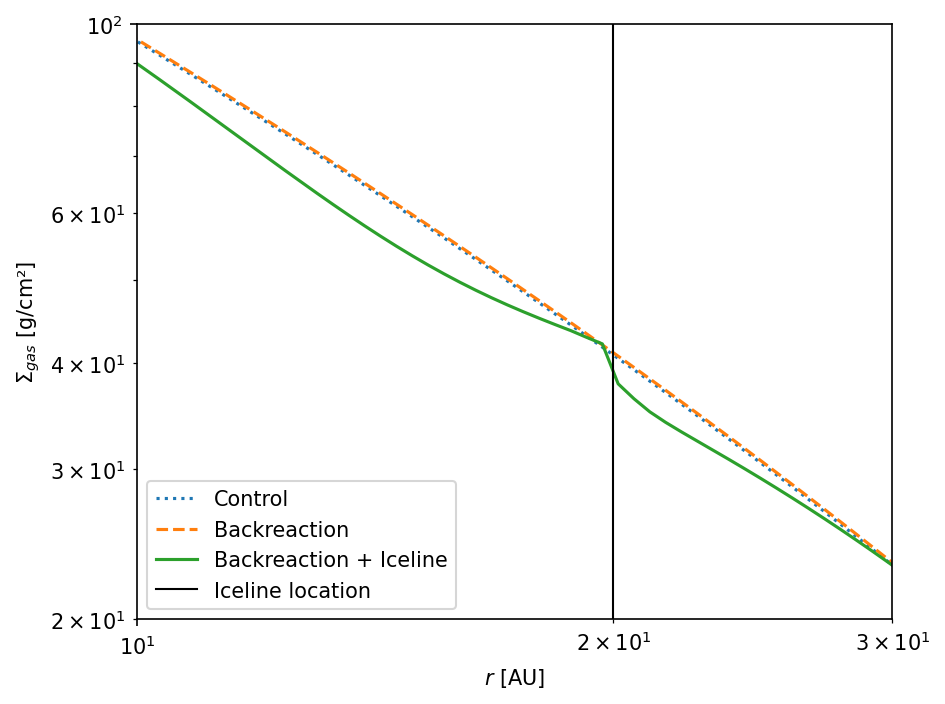

In [19]:
fig, ax = plt.subplots()
ax.loglog(r/c.au, sim_control.gas.Sigma, ls=':', label = 'Control')
ax.loglog(r/c.au, sim_backreaction.gas.Sigma, ls='--', label = 'Backreaction')
ax.loglog(r/c.au, sim_backreaction_iceline.gas.Sigma, ls='-', label = 'Backreaction + Iceline')
ax.axvline(r_iceline/c.au, lw=1, c="black", label="Iceline location")
ax.set_xlim([10,30])
ax.set_ylim([20,100])
ax.set_xlabel('$r$ [AU]')
ax.set_ylabel(r'$\Sigma_{gas}$ [g/cm²]')
ax.legend()
fig.tight_layout()

From the surface density profiles we see just about no difference between the `Control` and `Backreaction` simulations.

However we see that the gas surface density has changed when the iceline was considered in a high dust-to-gas ratio disk, creating a small bump in the disk.

Let's take a look at the gas velocities, which are now a contribution of two terms: a damped viscous accretion, and a backreaction push against the pressure gradient.

$\Large v_{r, \mathrm{gas}} = A v_\nu + 2B v_\eta$

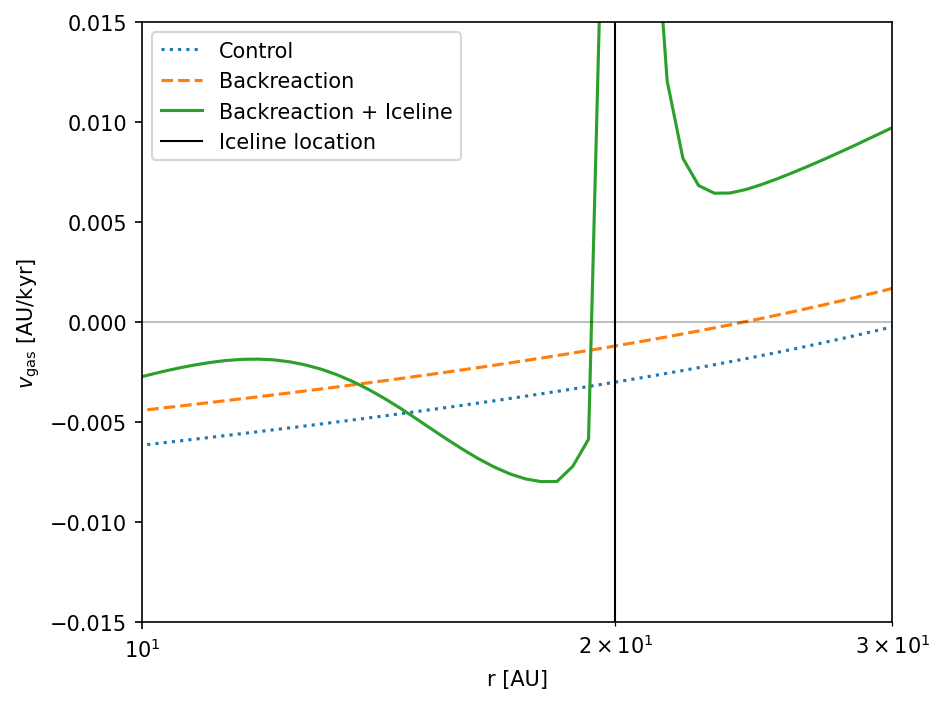

In [20]:
fig, ax = plt.subplots()
ax.semilogx(r/c.au, sim_control.gas.v.rad/(c.au/(1.e3*c.year)), ls=':', label = 'Control')
ax.semilogx(r/c.au, sim_backreaction.gas.v.rad/(c.au/(1.e3*c.year)), ls='--', label = 'Backreaction')
ax.semilogx(r/c.au, sim_backreaction_iceline.gas.v.rad/(c.au/(1.e3*c.year)), ls='-', label = 'Backreaction + Iceline')
ax.axvline(r_iceline/c.au, lw=1, c="black", label="Iceline location")
ax.axhline(0., lw=1, ls="-", c="black", alpha=0.25)
ax.set_xlim([10,30])
ax.set_ylim([-1.5e-2,1.5e-2])
ax.set_xlabel('r [AU]')
ax.set_ylabel(r'$v_\mathrm{gas}$ [AU/kyr]')
ax.legend()
fig.tight_layout()

Now the difference in the radial velocity of the gas is clear.

In the simulation with the iceline, the backreaction effect is strong enough to revert the gas flow at the snowline location, which leads to the creation of the small bump in the disk.




As a rule of thumb, the backreaction pushing term becomes dominant over the viscous evolution when:

$\Large \alpha A \lesssim B$

which is approximately equivalent to:


$\Large 1 \lesssim \mathrm{St}\, \epsilon\, \alpha^{-1}$

In [21]:
A_control = sim_control.dust.backreaction.A
A_backreaction = sim_backreaction.dust.backreaction.A
A_iceline = sim_backreaction_iceline.dust.backreaction.A
B_control = sim_control.dust.backreaction.B
B_backreaction = sim_backreaction.dust.backreaction.B
B_iceline = sim_backreaction_iceline.dust.backreaction.B
alpha = sim_control.gas.alpha

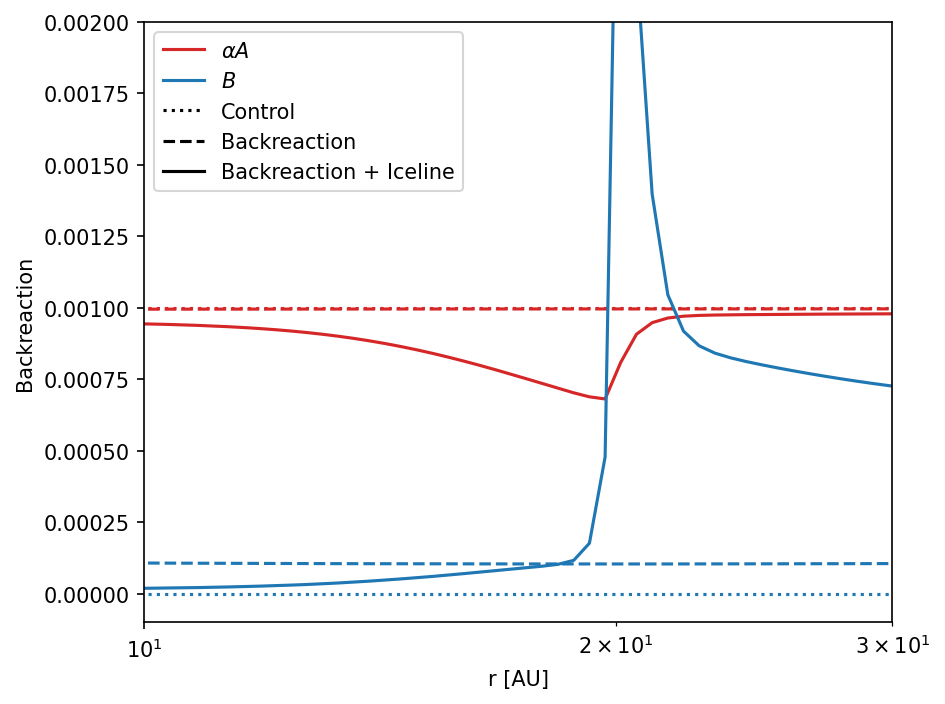

In [22]:
fig, ax = plt.subplots()

ax.semilogx(r/c.au, A_control * alpha, c="C3", ls=':')
ax.semilogx(r/c.au, A_backreaction * alpha, c="C3", ls='--')
ax.semilogx(r/c.au, A_iceline * alpha, c="C3", ls='-')
ax.semilogx(r/c.au, B_control, c="C0", ls=':')
ax.semilogx(r/c.au, B_backreaction, c="C0", ls='--')
ax.semilogx(r/c.au, B_iceline, c="C0", ls='-')

ax.semilogx(r/c.au, -np.ones_like(r), c="C3", label = r'$\alpha A$')
ax.semilogx(r/c.au, -np.ones_like(r), c="C0", label = '$B$')
ax.semilogx(r/c.au, -np.ones_like(r), c="black", ls=':', label = 'Control')
ax.semilogx(r/c.au, -np.ones_like(r), c="black", ls='--', label = 'Backreaction')
ax.semilogx(r/c.au, -np.ones_like(r), c="black", ls='-' , label = 'Backreaction + Iceline')
ax.legend()

ax.set_xlim([10,30])
ax.set_ylim([-1.e-4,2.e-3])
ax.set_xlabel('r [AU]')
ax.set_ylabel(r'Backreaction')

fig.tight_layout()

This plot show that in the `Backreaction + Iceline` simulation the backreaction coefficient $B$, that pushes the gas against the pressure gradient, dominates over the viscous spreading measured by $\alpha A$ (i.e. viscous spreading with backreaction damping)

In contrast, the `Backreaction` simulation without the iceline and a normal dust-to-gas ratio only shows a mild pushing coefficient, with $B \ll \alpha A$, which indicates that the evolution is mostly viscous.

We note that the backreaction effects only last while the dust continues to flow across the disk, and weakens if the dust-to-gas ratio decreases.